<a href="https://colab.research.google.com/github/ZoraizQ/brain_mas_classifier/blob/master/brain_mas_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier for Human Brain Mental Attention State using EEG BCI-based data

In [113]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model
from sklearn.utils import shuffle



SAMP_FREQ = 128 # SAMPLING FREQUENCY Hz (samples/second)
CLASSES = {
    0: 'focused',
    1: 'unfocused',
    2: 'drowsy'
}

ONEHOT = {
    0: np.array([1,0,0]),
    1: np.array([0,1,0]),
    2: np.array([0,0,1])
}

In [114]:
# ! pip install --upgrade --force-reinstall --no-deps kaggle

# from google.colab import files
# files.upload() #upload kaggle.json

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [115]:
! [ ! -d /content/data ] && kaggle datasets download -d 'inancigdem/eeg-data-for-mental-attention-state-detection' -p '/content/data' --unzip

# Data Preprocessing

In [116]:
DATA_FOLDER = '/content/data'

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.mat')))

NUM_FILES_ALL = len(filenames) # with habituation and trial experiments both
print("Total number of records: " + str(NUM_FILES_ALL))

'''
Each participant took part in 7 experiments, performing at most one experiment per day. 
The first 2 experiments were used for habituation, and the last 5 trials were used for collecting the data. 
The first 7 experiments belong to Subject 1, the next 7 experiments belong to Subject 2, and go on. 
However, Subject 5 could not complete the last experiment. 
Therefore, there are 34 records in the dataset.
'''


img_folder_path = '/'.join(filenames[0].split('/')[:-1])
filenames_trials = []  # remove records of habituation first, second of each subject's set out of 7
for i in range(3, NUM_FILES_ALL, 7):
    for j in range(i, min(i+5, NUM_FILES_ALL+1)):
        filenames_trials.append(img_folder_path+'/'+'eeg_record'+str(j)+'.mat')

print(filenames_trials)
NUM_FILES = len(filenames_trials)
print("Number of trial experiment records: " + str(NUM_FILES))

Total number of records: 34
['/content/data/EEG Data/eeg_record3.mat', '/content/data/EEG Data/eeg_record4.mat', '/content/data/EEG Data/eeg_record5.mat', '/content/data/EEG Data/eeg_record6.mat', '/content/data/EEG Data/eeg_record7.mat', '/content/data/EEG Data/eeg_record10.mat', '/content/data/EEG Data/eeg_record11.mat', '/content/data/EEG Data/eeg_record12.mat', '/content/data/EEG Data/eeg_record13.mat', '/content/data/EEG Data/eeg_record14.mat', '/content/data/EEG Data/eeg_record17.mat', '/content/data/EEG Data/eeg_record18.mat', '/content/data/EEG Data/eeg_record19.mat', '/content/data/EEG Data/eeg_record20.mat', '/content/data/EEG Data/eeg_record21.mat', '/content/data/EEG Data/eeg_record24.mat', '/content/data/EEG Data/eeg_record25.mat', '/content/data/EEG Data/eeg_record26.mat', '/content/data/EEG Data/eeg_record27.mat', '/content/data/EEG Data/eeg_record28.mat', '/content/data/EEG Data/eeg_record31.mat', '/content/data/EEG Data/eeg_record32.mat', '/content/data/EEG Data/eeg_re

data: (357224, 25)


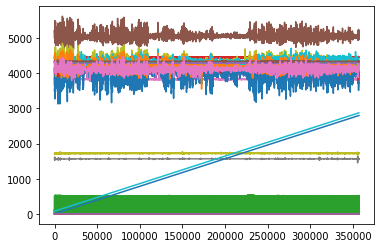


data_eeg: (357224, 14)


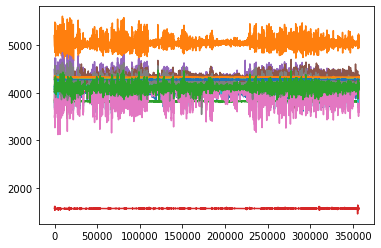


timestamp: (357224, 6)


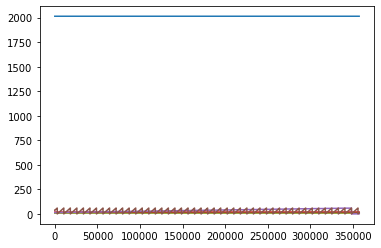


marker: (357224, 1)
(127656, 127787, 255540, 255671)


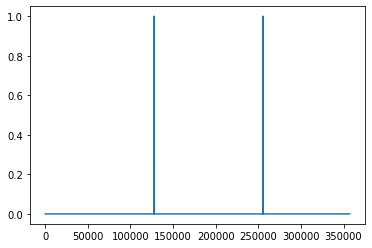


trials: (1, 2, 14, 128)



In [117]:
'''
Each Matlab file contains the object of the data acquired from EMOTIV device during one experiment. 
The raw data is contained in o.data, which is array of size {number-of-samples}x25, thus o.data(:,i) comprises one data channel. 
The sampling frequency is 128 Hz. The list of data channels and their numerical ids is given below per EMOTIV documentation;

25 CHANNELS:

1-'EDCOUNTER' 2-'EDINTERPOLATED'
3-'EDRAWCQ'
------------
4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'
--------------
18-'EDGYROX' 19-'EDGYROY'
20-'EDTIMESTAMP' 21-'EDESTIMESTAMP' 22-'EDFUNCID' 23-'EDFUNCVALUE' 24-'EDMARKER'
25'EDSYNCSIGNAL'

The EEG data is in the channels 4:17.

-----------------------------------

Every experiments have same labels:
Focuse: 0 to 10 min
Unfocused: 10 to 20min
Sleep: 20 to end of experiments

Checking by markers.
'''

def get_marker_endpoints(marker): # marker eeg data array with 2 markers
    marker_indexes = np.where(marker>0)[0]
    diff_values = np.diff(marker_indexes)
    split_index = np.where(diff_values >= 3000)[0] # difference of 3000s
    split_index += 1
    markers_split = np.split(marker_indexes, split_index)

    if len(markers_split) == 1:
        focus_end_ts = markers_split[0][0]
        unfocus_start_ts = markers_split[0][-1]
        return focus_end_ts-1, unfocus_start_ts+1

    elif len(markers_split) == 2:
        marker1, marker2 = markers_split
        focus_end_ts = marker1[0]
        unfocus_start_ts = marker1[-1]
        unfocus_end_ts = marker2[0]
        drowsy_start_ts = marker2[-1]
        return focus_end_ts-1, unfocus_start_ts+1, unfocus_end_ts-1, drowsy_start_ts+1, -1

    elif len(markers_split) == 3:
        marker1, marker2, marker3 = markers_split
        focus_end_ts = marker1[0]
        unfocus_start_ts = marker1[-1]
        unfocus_end_ts = marker2[0]
        drowsy_start_ts = marker2[-1]
        drowsy_end_ts = marker3[0]

        return focus_end_ts-1, unfocus_start_ts+1, unfocus_end_ts, drowsy_start_ts+1, drowsy_end_ts



record = loadmat(filenames_trials[0])
mdata = record['o']  # main object 
sample1 = {n: mdata[n][0,0] for n in mdata.dtype.names}

marker = sample1['marker']
timestamp = sample1['timestamp']
data = sample1['data']
trials = sample1['trials']

print('data:', data.shape)
plt.plot(data)
plt.show()

data_eeg = data[:,4:18]
print('\ndata_eeg:', data_eeg.shape)
plt.plot(data_eeg)
plt.show()


print('\ntimestamp:', timestamp.shape)
plt.plot(timestamp)
plt.show()

print('\nmarker:', marker.shape)
print(get_markers_endpoints(marker))
plt.plot(marker)
plt.show()

print('\ntrials:', trials.shape)
print()


In [118]:
X = []
y = []

USE_MARKERS = False

mark_10min, mark_20min = 10*60*SAMP_FREQ, 20*60*SAMP_FREQ 

for fn in filenames_trials:
    record = loadmat(fn)
    mdata = record['o']  # main object 
    ndata = {n: mdata[n][0,0] for n in mdata.dtype.names}

    data = ndata['data'][:,4:18] # 4-17 EEG data channels only
    ns = data.shape[0]

    # print(fn.split('/')[-1])
    # plt.plot(ndata['marker'])
    # plt.show()
    # plt.plot(data)
    # plt.show()
    # print()

    if USE_MARKERS:
        marker_endpoints = get_marker_endpoints(ndata['marker'])

        if len(marker_endpoints) == 2:
            focus_end_ts, unfocus_start_ts = marker_endpoints

            X.append(data[:focus_end_ts]) # from the start
            y.append(ONEHOT[0]) # focused

            X.append(data[unfocus_start_ts:])
            y.append(ONEHOT[1]) # unfocused
        
        else:
            focus_end_ts, unfocus_start_ts, unfocus_end_ts, drowsy_start_ts, drowsy_end_ts = marker_endpoints
        
            X.append(data[:focus_end_ts]) # from the start
            y.append(ONEHOT[0]) # focused

            X.append(data[unfocus_start_ts:unfocus_end_ts])
            y.append(ONEHOT[1]) # unfocused

            X.append(data[drowsy_start_ts:drowsy_end_ts]) # until the end
            y.append(ONEHOT[2]) # drowsy

    else:
        X.append(data[:mark_10min-1]) # from the start
        y.append(ONEHOT[0]) # focused

        X.append(data[mark_10min+1:mark_20min-1])
        y.append(ONEHOT[1]) # unfocused

        X.append(data[mark_20min+1:]) # until the end
        y.append(ONEHOT[2]) # drowsy


print(len(X), len(y))

72 72


55 55
focused


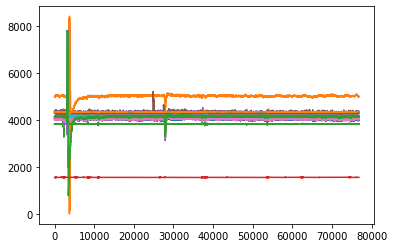


focused


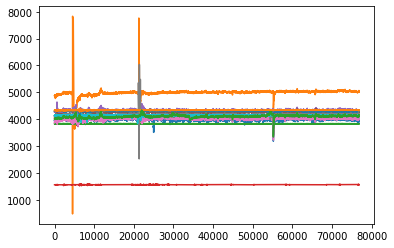


unfocused


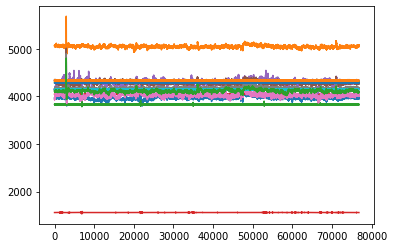


drowsy


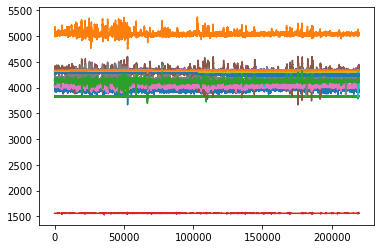


drowsy


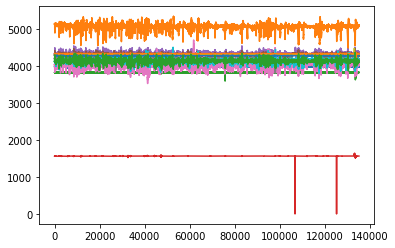


drowsy


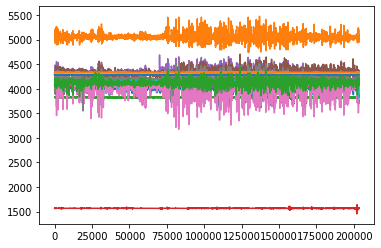


drowsy


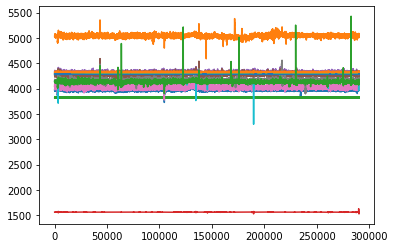


unfocused


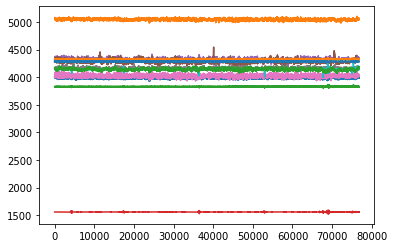


unfocused


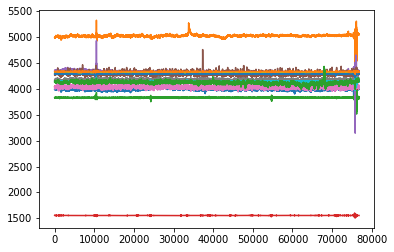


focused


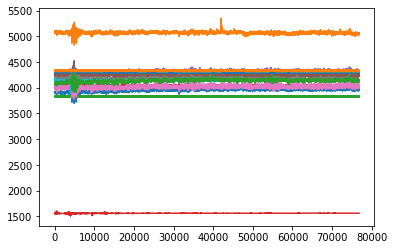

In [126]:
NUM_TRAIN = 55

# unshuffled so class balanced
X_train = X[:NUM_TRAIN]
y_train = y[:NUM_TRAIN]

X_test = X[NUM_TRAIN:]
y_test = y[NUM_TRAIN:]

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)


print(len(X_train), len(y_train))

for i in range(10):
    print(CLASSES[np.argmax(y_train[i])])
    plt.plot(X_train[i])
    plt.show()
    print()